In [1]:
%pip install kagglehub
%pip install pandas
%pip install -U jupyter ipywidgets
%pip install -U jupyterlab-widgets
%pip install seaborn
%pip install tabulate
%pip install statsmodels --index-url=https://pypi.org/simple
%pip install sklearn
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pi

**LIBRERIE NECESSARIE**

In [2]:
from tabulate import tabulate
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

**INFORMAZIONI SUL DATASET**

In [3]:
# Scaricare il dataset da Kaggle (simulato in locale per questo esempio)
path = kagglehub.dataset_download("khushipitroda/stock-market-historical-data-of-top-10-companies")
file_path = os.path.join(path, "data.csv")

# Leggere il file CSV
df = pd.read_csv(file_path)

# Stampare numero di righe nel dataset
print(f"Numero di righe nel dataset: {df.shape[0]}\n")

# Stampare le prime righe in una tabella formattata
print("Prime righe del dataset:\n")
print(tabulate(df.head(), headers='keys', tablefmt='grid'))

# Stampare le ultime righe in una tabella formattata
print("\nUltime righe del dataset:\n")
print(tabulate(df.tail(), headers='keys', tablefmt='grid'))

Numero di righe nel dataset: 25160

Prime righe del dataset:

+----+-----------+------------+--------------+----------+---------+-----------+---------+
|    | Company   | Date       | Close/Last   |   Volume | Open    | High      | Low     |
+====+===========+============+==============+==========+=========+===========+=========+
|  0 | AAPL      | 07/17/2023 | $193.99      | 50520160 | $191.90 | $194.32   | $191.81 |
+----+-----------+------------+--------------+----------+---------+-----------+---------+
|  1 | AAPL      | 07/14/2023 | $190.69      | 41616240 | $190.23 | $191.1799 | $189.63 |
+----+-----------+------------+--------------+----------+---------+-----------+---------+
|  2 | AAPL      | 07/13/2023 | $190.54      | 41342340 | $190.50 | $191.19   | $189.78 |
+----+-----------+------------+--------------+----------+---------+-----------+---------+
|  3 | AAPL      | 07-12-2023 | $189.77      | 60750250 | $189.68 | $191.70   | $188.47 |
+----+-----------+------------+-------

**FASE DI ETL**

In [4]:
# Rimuovere duplicati
df_cleaned = df.drop_duplicates()

# Rimuovere valori nulli
df_cleaned = df.dropna()

print(f"Numero di righe nel dataset senza valori nulli: {df_cleaned.shape[0]}")
# Rinominare le colonne
df_cleaned = df_cleaned.rename(columns={
    'Date': 'date',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close/Last': 'close/last',
    'Volume': 'volume',
    'Company': 'company'
})

# Funzione per convertire i formati delle date
def correct_date_format(date):
    try:
        # Tenta di interpretare la data come MM/DD/YYYY (o MM-DD-YYYY)
        if '-' in date or '/' in date:
            return pd.to_datetime(date, dayfirst=False, errors='coerce').strftime('%d/%m/%Y')
        else:
            return date  # Restituisci la data originale se non è in un formato valido
    except Exception as e:
        print(f"Errore durante la conversione della data: {date}")
        return None  # Restituisci None per valori non validi

# Applicare la funzione alla colonna 'date'
df_cleaned['date'] = df_cleaned['date'].astype(str).apply(correct_date_format)

# Pulizia e conversione della colonna 'close/last'
df_cleaned['close/last'] = df_cleaned['close/last'].replace('[\$,]', '', regex=True).astype(float)

# Aggiungere colonne derivate
df_cleaned['daily_return'] = df_cleaned['close/last'].pct_change() * 100
df_cleaned['rolling_average_7d'] = df_cleaned['close/last'].rolling(window=7).mean()
df_cleaned['rolling_average_30d'] = df_cleaned['close/last'].rolling(window=30).mean()

# Visualizzazione dei risultati
# Head
print("Primi dati:\n")
print(tabulate(df_cleaned.head(), headers='keys', tablefmt='grid'))

# Tail
print("\nUltimi dati:\n")
print(tabulate(df_cleaned.tail(), headers='keys', tablefmt='grid'))

# Salvare il dataset pulito in un nuovo file
output_file = 'cleaned_stock_market.csv'
df_cleaned.to_csv(output_file, index=False)
print(f"\nDataset pulito e salvato in: {output_file}")

Numero di righe nel dataset senza valori nulli: 25160
Primi dati:

+----+-----------+------------+--------------+----------+---------+-----------+---------+----------------+----------------------+-----------------------+
|    | company   | date       |   close/last |   volume | open    | high      | low     |   daily_return |   rolling_average_7d |   rolling_average_30d |
+====+===========+============+==============+==========+=========+===========+=========+================+======================+=======================+
|  0 | AAPL      | 17/07/2023 |       193.99 | 50520160 | $191.90 | $194.32   | $191.81 |    nan         |                  nan |                   nan |
+----+-----------+------------+--------------+----------+---------+-----------+---------+----------------+----------------------+-----------------------+
|  1 | AAPL      | 14/07/2023 |       190.69 | 41616240 | $190.23 | $191.1799 | $189.63 |     -1.70112   |                  nan |                   nan |
+----+---

In [5]:
# Caricamento del dataset
df = pd.read_csv("cleaned_stock_market.csv")

# Informazioni generali sul dataset
print("Informazioni generali sul dataset:")
df_info = pd.DataFrame({
    "Column": df.columns,
    "Non-Null Count": df.notnull().sum().values,
    "Dtype": df.dtypes.values
})
print(tabulate(df_info, headers="keys", tablefmt="grid"))

# Statistiche descrittive
print("\nStatistiche descrittive:")
df_stats = df.describe().T  # Transpose for better readability
print(tabulate(df_stats, headers="keys", tablefmt="grid"))


Informazioni generali sul dataset:
+----+---------------------+------------------+---------+
|    | Column              |   Non-Null Count | Dtype   |
+====+=====================+==================+=========+
|  0 | company             |            25160 | object  |
+----+---------------------+------------------+---------+
|  1 | date                |            25160 | object  |
+----+---------------------+------------------+---------+
|  2 | close/last          |            25160 | float64 |
+----+---------------------+------------------+---------+
|  3 | volume              |            25160 | int64   |
+----+---------------------+------------------+---------+
|  4 | open                |            25160 | object  |
+----+---------------------+------------------+---------+
|  5 | high                |            25160 | object  |
+----+---------------------+------------------+---------+
|  6 | low                 |            25160 | object  |
+----+---------------------+---------

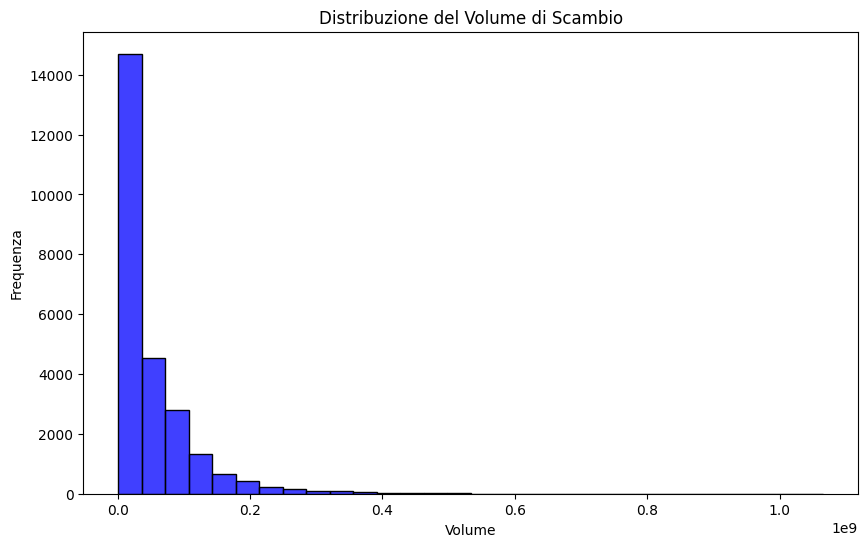

In [6]:
# Istogramma del volume di scambio
plt.figure(figsize=(10, 6))
sns.histplot(df['volume'], kde=False, bins=30, color='blue')
plt.title('Distribuzione del Volume di Scambio')
plt.xlabel('Volume')
plt.ylabel('Frequenza')
plt.savefig('volume_histogram.png')
plt.show()

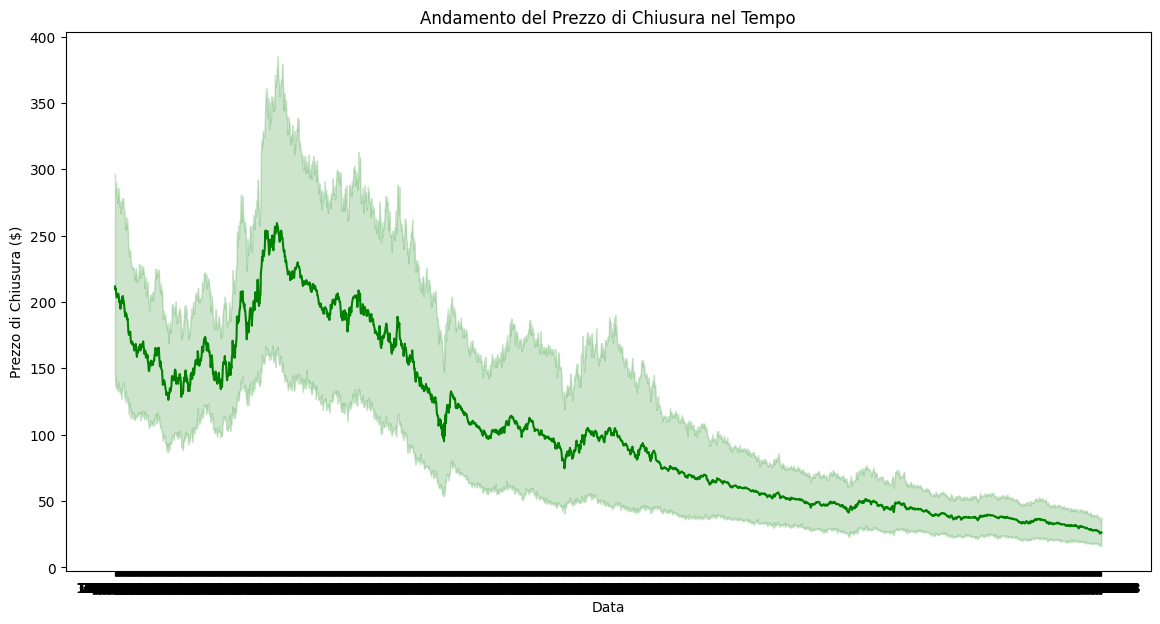

In [7]:
# Grafico a linee per l'andamento del prezzo di chiusura
plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='close/last', data=df, color='green')
plt.title('Andamento del Prezzo di Chiusura nel Tempo')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura ($)')
plt.savefig('line_plot_close.png')
plt.show()

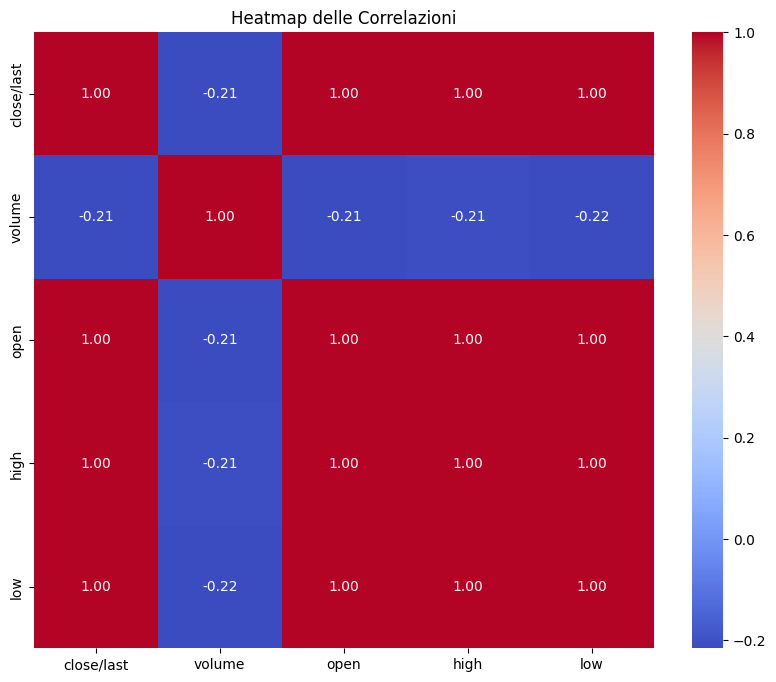

In [8]:
# Conversione delle colonne 'open', 'high', e 'low' in float
columns_to_convert = ['open', 'high', 'low']

for col in columns_to_convert:
    df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

# Heatmap delle correlazioni
plt.figure(figsize=(10, 8))
corr = df[['close/last', 'volume', 'open', 'high', 'low']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap delle Correlazioni')
plt.savefig('heatmap_corr.png')
plt.show()

**INIZIO SERIE TEMPORALI**

In [9]:
# Caricamento dei dati
df = pd.read_csv("cleaned_stock_market.csv")

# Selezionare la serie temporale di interesse (esempio: Apple)
df_apple = df[df['company'] == 'AAPL'][['date', 'close/last']].set_index('date')

# Controllo dati mancanti
print("Valori mancanti prima della pulizia:")
print(df_apple.isnull().sum())

# Rimuovere righe con date mancanti
df_apple = df_apple.dropna(subset=['close/last'])

# Convertire la colonna delle date in datetime e impostarla come indice
df_apple.index = pd.to_datetime(df_apple.index, dayfirst=True, format='%d/%m/%Y')

# Ordinare i dati per data
df_apple = df_apple.sort_index()

# Interpolazione per gestire eventuali lacune
df_apple = df_apple.asfreq('D')  # Imposta una frequenza giornaliera
df_apple['close/last'] = df_apple['close/last'].interpolate(method='linear')

# Controllo finale
print("Valori mancanti dopo la pulizia:")
print(df_apple.isnull().sum())

Valori mancanti prima della pulizia:
close/last    0
dtype: int64
Valori mancanti dopo la pulizia:
close/last    0
dtype: int64


**DECOMPOSIZIONE SERIE TEMPORALE**

Frequenza rilevata: D


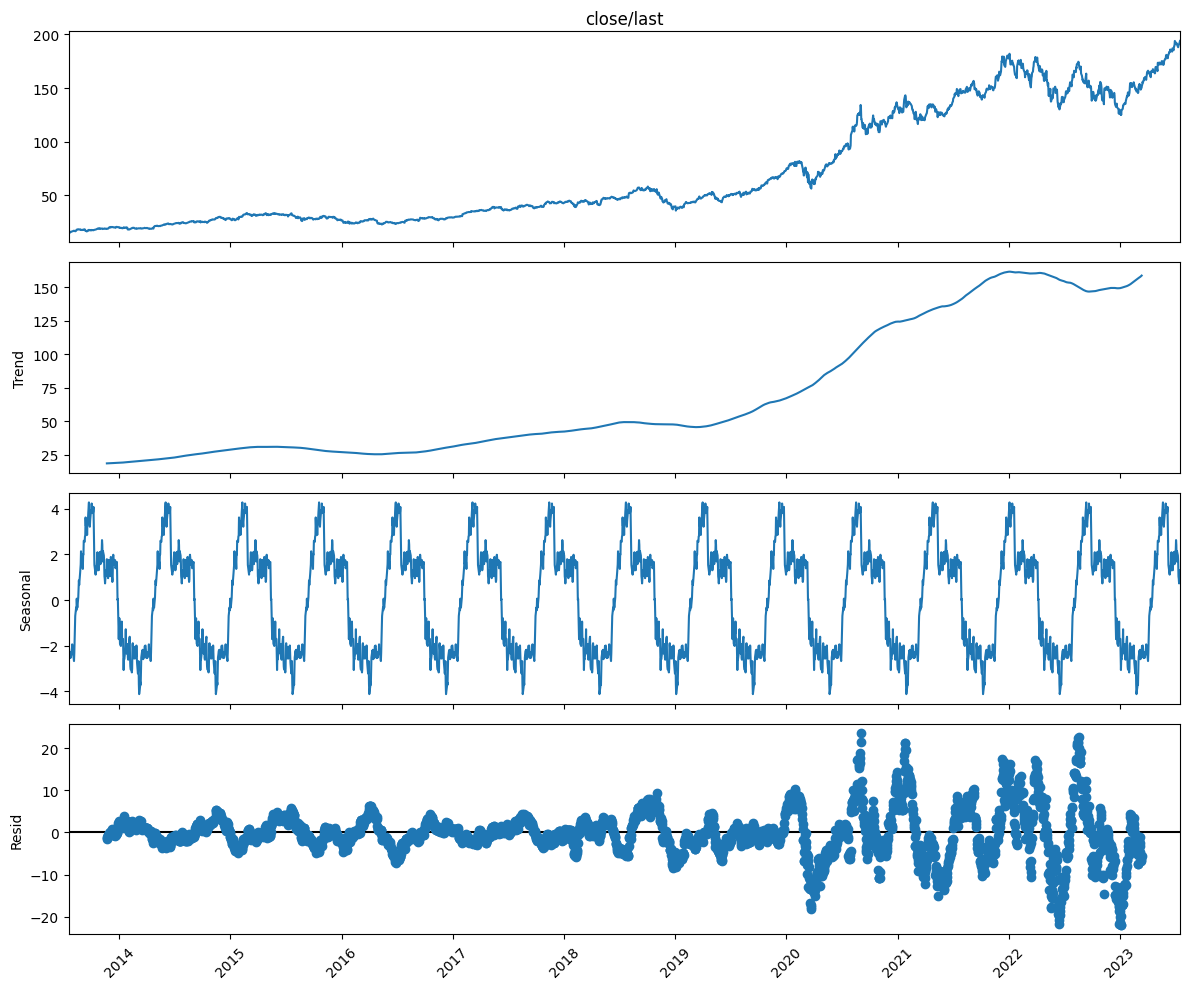

In [10]:
# Assicurati che l'indice sia di tipo datetime e ordinato
if not isinstance(df_apple.index, pd.DatetimeIndex):
    df_apple.index = pd.to_datetime(df_apple.index)

df_apple = df_apple.sort_index()

# Verifica che non ci siano valori mancanti nella colonna 'close/last'
if df_apple['close/last'].isnull().any():
    print("Ci sono valori mancanti nella colonna 'close/last'. Verranno rimossi.")
    df_apple = df_apple.dropna(subset=['close/last'])

# Determina automaticamente la frequenza dei dati
freq = df_apple.index.inferred_freq
print(f"Frequenza rilevata: {freq}")

# Imposta il periodo in base alla frequenza
if freq == 'D':  # Dati giornalieri
    period = 252  # Stagionalità annuale (252 giorni di trading)
elif freq == 'W':  # Dati settimanali
    period = 52  # Stagionalità annuale (52 settimane)
elif freq == 'M':  # Dati mensili
    period = 12  # Stagionalità annuale (12 mesi)
else:
    print("Frequenza non riconosciuta. Utilizzo il periodo predefinito per dati giornalieri.")
    period = 252

# Decomposizione additiva
try:
    decomposition = seasonal_decompose(df_apple['close/last'], model='additive', period=period)

    # Plot della decomposizione
    fig = decomposition.plot()

    # Imposta la dimensione del grafico
    fig.set_size_inches(12, 10)

    # Intervallo personalizzato per i tick dell'asse x
    xticks_interval = 252  # Intervallo di un anno per dati giornalieri
    xticks = pd.date_range(start=df_apple.index.min(), end=df_apple.index.max(), freq='YS')
    
    for ax in fig.axes:
        ax.set_xticks(xticks)
        ax.set_xticklabels([tick.strftime('%Y') for tick in xticks], rotation=45)

    # Ottimizza lo spazio tra i sottografi
    plt.tight_layout()
    plt.show()

except ValueError as e:
    print(f"Errore durante la decomposizione: {e}")
    print("Verifica che la serie temporale abbia una lunghezza sufficiente rispetto al periodo.")




In [11]:
# Test Dickey-Fuller
result = adfuller(df_apple['close/last'])

# Stampa i risultati
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")

ADF Statistic: 0.6861245831836653
p-value: 0.9895568550388314
Critical Values: {'1%': np.float64(-3.4321522387754775), '5%': np.float64(-2.862336328589075), '10%': np.float64(-2.567193897993964)}


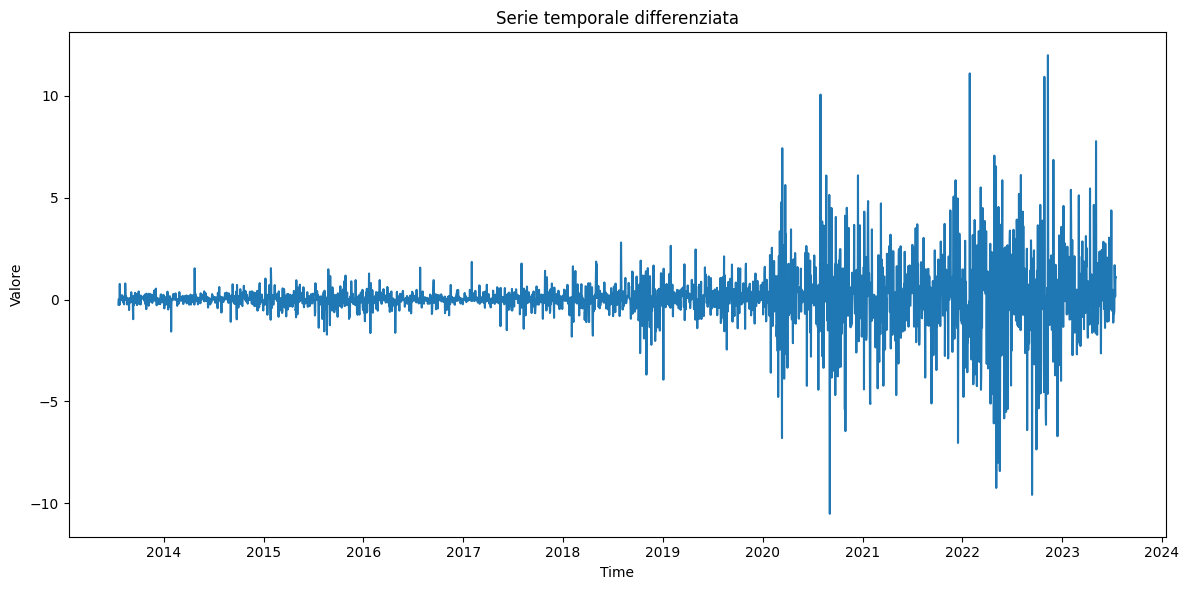

In [12]:
# Differenziazione della serie temporale
differenced_data = df_apple['close/last'].diff().dropna()

# Generazione della figura
plt.figure(figsize=(12, 6))
plt.plot(differenced_data)
plt.title('Serie temporale differenziata')
plt.xlabel('Time')
plt.ylabel('Valore')
plt.tight_layout()
plt.savefig('differenced_series.png')

In [18]:
# Differenziazione della serie temporale
df_apple['diff_close/last'] = df_apple['close/last'].diff().dropna()
# Verifica della stazionarieta' della serie differenziata
result_diff = adfuller(df_apple['diff_close/last'].dropna())
print(f"ADF Statistic (differenziata): {result_diff[0]}")
print(f"p-value (differenziata): {result_diff[1]}")
print(f"Critical Values (differenziata): {result_diff[4]}")

ADF Statistic (differenziata): -11.315375863363592
p-value (differenziata): 1.210296556810467e-20
Critical Values (differenziata): {'1%': np.float64(-4.223238279489106), '5%': np.float64(-3.189368925619835), '10%': np.float64(-2.729839421487603)}


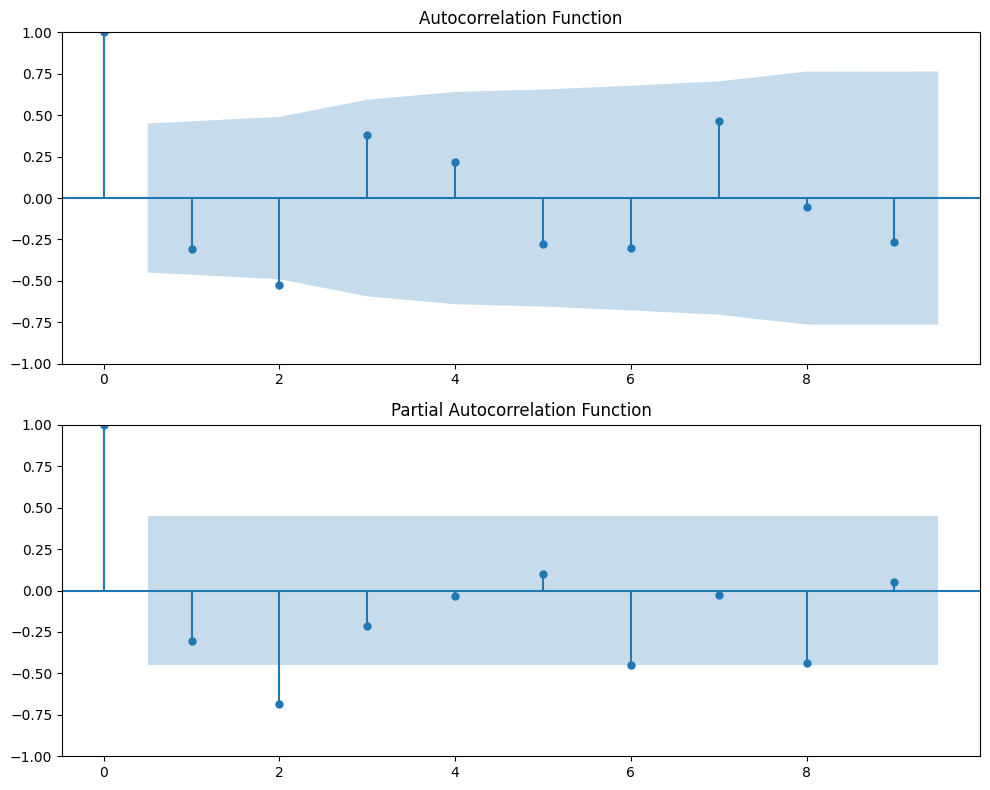

In [14]:
# Create a larger example dataset
df_apple = pd.DataFrame({
    'close/last': [150, 152, 153, 155, 157, 159, 160, 158, 162, 164, 
                   163, 165, 168, 170, 169, 172, 174, 173, 175, 177]
})

# Calculate differences
differenced_data = df_apple['close/last'].diff().dropna()

# Calculate maximum allowed lags (50% of sample size)
max_lags = len(differenced_data) // 2

# Create plots with appropriate number of lags
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF
plot_acf(differenced_data, lags=max_lags, ax=axes[0])
axes[0].set_title('Autocorrelation Function')

# Plot PACF
plot_pacf(differenced_data, lags=max_lags, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [15]:
# Modello ARIMA
arima_model = ARIMA(df_apple['close/last'], order=(2, 1, 2))
arima_fit = arima_model.fit()

# Modello SARIMAX
sarimax_model = SARIMAX(df_apple['close/last'], 
                        order=(2, 1, 2), 
                        seasonal_order=(1, 1, 1, 252))
sarimax_fit = sarimax_model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [16]:
arima_rmse = np.sqrt(mean_squared_error(df_apple['close/last'][-30:], arima_fit.fittedvalues[-30:]))
sarimax_rmse = np.sqrt(mean_squared_error(df_apple['close/last'][-30:], sarimax_fit.fittedvalues[-30:]))

print(f"RMSE ARIMA: {arima_rmse}")
print(f"RMSE SARIMAX: {sarimax_rmse}")

RMSE ARIMA: 33.589808250879756
RMSE SARIMAX: 33.60282726200282
